In [7]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
import scipy.stats as stats
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from matplotlib.colors import LinearSegmentedColormap


import geopandas as gpd
from mpl_toolkits.basemap import Basemap as Basemap


import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [3]:
#lump all trajectories together and calculate energy score for each location/scenario

In [7]:
# include all models, even those only submitting for one location

locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})

modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']

incidence = True 
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


energyscoresdf = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
loclist = list(predictionsall.location.unique())


for loc in loclist:
    if loc in ['60','66','69', '72', '78']:
        continue
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        location = loc
        target = 'hosp'
        incidence = True

        if target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = target_obs

        predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                    (predictionsall.location == location) & \
                                    (predictionsall.target == 'inc ' + target)  & \
                                    (predictionsall.target_end_date <= max_date) & \
                                    (predictionsall.target_end_date >= start_week)]

        # get observations
        observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
        observations['date'] = pd.to_datetime(observations['date'])

        observations = observations[(observations['date'] >= start_week) & \
                                    (observations['date'] <= max_date)]   

        #filter location
        observations = observations[observations['location'] == location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        #transform to Observation object
        observations = Observations(observations)


        y = np.array(observations.value)
        X = [np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) for i in predictionsfilt.trajectory_id.unique()]

        ES = energyscore(np.array(X),y)
        
        if loc == 'US':
            loc_conv = loc
        elif int(loc) <10:
            loc_conv = loc[1]
        else:
            loc_conv = loc  

        newrow = pd.DataFrame({'Label': 'Scenario '+ scenario, 'location':loc_conv,  
                            'target':target, 'energyscore': ES}, index=[0])

        energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')


In [8]:
energyscoresdf

,Label,location,target,energyscore,abbreviation,location_name,population
0,Scenario A,6,hosp,2408.186334,CA,California,39512223
1,Scenario B,6,hosp,2085.438587,CA,California,39512223
2,Scenario C,6,hosp,3243.165682,CA,California,39512223
3,Scenario D,6,hosp,2444.652925,CA,California,39512223
4,Scenario E,6,hosp,4044.816078,CA,California,39512223
...,...,...,...,...,...,...,...
307,Scenario B,56,hosp,84.160215,WY,Wyoming,578759
308,Scenario C,56,hosp,83.395302,WY,Wyoming,578759
309,Scenario D,56,hosp,82.510690,WY,Wyoming,578759
310,Scenario E,56,hosp,85.894929,WY,Wyoming,578759


In [9]:
energyscoresdf.to_pickle("../fludat/energyscore_trajensemble_rd4_hosp_118.pkl")

# Map of ensemble energy score at each US state
create energy score ratio to compare ensemble to naive baseline model

In [9]:
baseline = pd.read_pickle('../fludat/flu-baseline_energyscore.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})
baseline = baseline[baseline.location!='US']
baseline['location'] = baseline['location'].astype(int)

ensembledf = pd.read_pickle("../fludat/energyscore_trajensemble_rd4_hosp_118.pkl")
ensembledf['target'] = 'inc hosp'
ensembledf= ensembledf[ensembledf.location!='US']
ensembledf['location'] = ensembledf['location'].astype(int)
ensembledf['Model'] = 'Ensemble'

ES_ratiodf = ensembledf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']

In [10]:
df = ES_ratiodf[['Model', 'Label', 'location', 'abbreviation', 'location_name', 'ES_ratio']]
df = df[(df.Label=='Scenario D') & (df.location != 'US') & (df.location != 11)]

In [11]:
df

,Model,Label,location,abbreviation,location_name,ES_ratio
3,Ensemble,Scenario D,6,CA,California,1.244085
9,Ensemble,Scenario D,1,AL,Alabama,0.771218
15,Ensemble,Scenario D,2,AK,Alaska,1.263516
21,Ensemble,Scenario D,4,AZ,Arizona,0.636306
27,Ensemble,Scenario D,5,AR,Arkansas,1.062505
33,Ensemble,Scenario D,8,CO,Colorado,0.724055
39,Ensemble,Scenario D,9,CT,Connecticut,1.192941
45,Ensemble,Scenario D,10,DE,Delaware,1.357589
57,Ensemble,Scenario D,12,FL,Florida,1.034621
63,Ensemble,Scenario D,13,GA,Georgia,0.568404


In [12]:
len(df[df.ES_ratio>1])

27

create map of scores

In [13]:
us = gpd.read_file('../cb_2018_us_state_500k')
us = us.rename(columns={'STATEFP':'location'})
us['location'] = us['location'].astype(int)

# Merge datasets
merged = us.merge(df.groupby(by='location').mean(), how='left', left_on='location', right_on='location')


<Axes: >

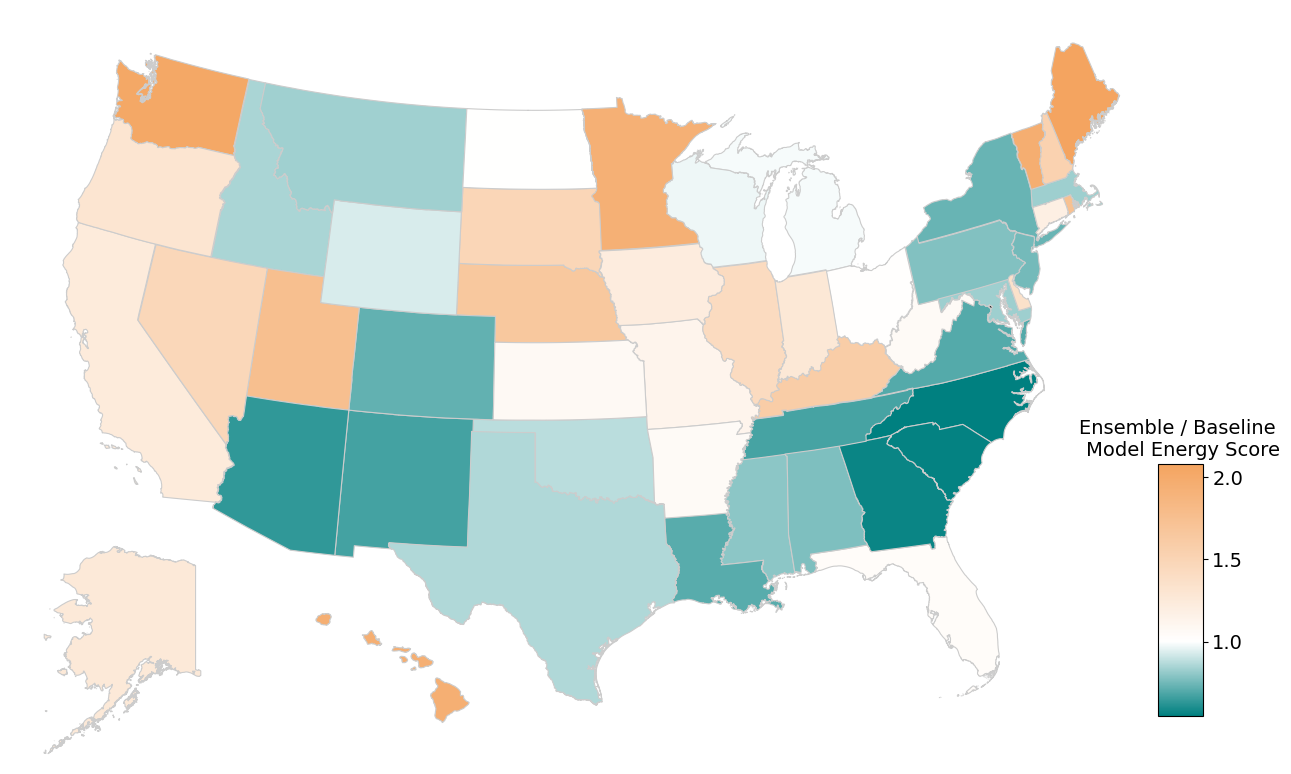

In [25]:
variable = 'ES_ratio'

colors = ['teal', 'white', 'sandybrown']
# Create a colormap from the list of colors
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)


def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

gdf = merged.copy()

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.ES_ratio.min(), gdf.ES_ratio.max() 
colormap = cmap
gdf = makeColorColumn(gdf,variable,vmin,vmax)
visframe = gdf.to_crs({'init':'epsg:2163'})


# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 12))
# remove the axis box around the vis
ax.axis('off')
#ax.set_xlim([-6,3])


# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.21])   

cbax.set_title('Ensemble / Baseline \n Model Energy Score', fontdict={'fontsize': '14', 'fontweight' : '0'})

# add color scale

sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax))


# reformat tick labels on legend
sm._A = []
cbar = fig.colorbar(sm, cax=cbax, spacing='proportional')
tick_font_size = 14
cbax.tick_params(labelsize=tick_font_size)
cbar.ax.set_yscale('linear')


# create map
for row in visframe.itertuples():
    if row.location not in [2, 15, 72, 69, 78, 60, 66]:
        vf = visframe[visframe.location==row.location]
        c = gdf[gdf.location==row.location][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.location==2]
alaska_gdf.clip(polygon).plot(color=gdf[gdf.location==2].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.2, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.location==15]
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


#fig.savefig('../figs/ESratio_ensemble_map1126.pdf', bbox_inches="tight")


# Multi-dimensional energy score for the ensemble

In [29]:
from numba import njit
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)**2)/np.sum(y,axis=1)[:, np.newaxis]))/ N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])**2)/np.sum(y,axis=1)[:, np.newaxis]))/(2*N**2)
    return ES


In [30]:
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>=pd.to_datetime('2023-09-09'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])


In [54]:
locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})

modelsall = ['MOBS_NEU-GLEAM_FLU','NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS']

incidence = True 
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


energyscoresdf = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]   

In [56]:
for loc in predictionsall.location.unique():
    if loc not in predictionsall[predictionsall.Model=='UT-ImmunoSEIRS'].location.unique():
        print(loc)

11
72
78
66
69
60


In [57]:
# filter by target and locations that all models predict (need same number of trajectories for each dimension)
predictionsdf = predictionsall[(predictionsall.target=='inc hosp') &\
                               (~predictionsall.location.isin(['11','60','66','69', '72', '78']))]
predictionsdf['Model'] = 'Ensemble'

In [70]:
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in predictionsdf.location.unique()])
locations = list(predictionsdf.location.unique())

energyscores_locations = pd.DataFrame()

for it in range(50):
    print(it)
    for model in ['Ensemble']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            
            dfall = pd.DataFrame()
            for loc in locations:
                
                predictionshosp = predictionsdf[(predictionsdf.scenario_id == scenario + '-2023-08-14') & \
                                            (predictionsdf.target_end_date <= hosp.date.max()) & \
                                            (predictionsdf.target_end_date >= hosp.date.min())&\
                                            (predictionsdf.Model == model) &\
                                            (predictionsdf.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id'].unique()), 
                                      k=len(list(predictionshosp['trajectory_id'].unique())))
                predictionshosp['new_id'] = predictionshosp['trajectory_id'].apply(lambda key: newid[key-1])

                dfall = pd.concat([dfall,predictionshosp])
                
            tlist = []
            for tid in dfall.new_id.unique():
                dfilt = dfall[dfall.new_id==tid]
                llist = []
                for loc in dfilt.location.unique():
                    d = dfilt[dfilt.location==loc].sort_values(by='target_end_date')
                    llist.append(list(d.value))
                    
                tlist.append(llist)
                

            A = np.array(tlist)
            
            #print(A)


            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'multidim',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [71]:
energyscores_locations

,Model,Label,location,energyscore,it
0,Ensemble,Scenario A,multidim,82.811276,0
1,Ensemble,Scenario B,multidim,75.522938,0
2,Ensemble,Scenario C,multidim,88.153061,0
3,Ensemble,Scenario D,multidim,76.084531,0
4,Ensemble,Scenario E,multidim,94.491402,0
...,...,...,...,...,...
295,Ensemble,Scenario B,multidim,75.447592,49
296,Ensemble,Scenario C,multidim,88.053905,49
297,Ensemble,Scenario D,multidim,76.135254,49
298,Ensemble,Scenario E,multidim,94.505492,49


In [72]:
energyscores_locations.to_pickle("../fludat/multidim_energyscore_ensemble_hosp.pkl")

In [73]:
# calculate multi-dimensional energy score ratio
baseline = pd.read_csv('../fludat/multitarget_loc_baseline_118.csv')
baselinemed = baseline.energyscore.median()

energyscores_locations['ES_ratio'] = energyscores_locations['energyscore'] / baselinemed


In [75]:
energyscores_locations.groupby('Label').median().to_csv('../fludat/multitarget_ensemble_ratio_median.csv')

In [76]:
energyscores_locations.groupby('Label').median()

,energyscore,it,ES_ratio
Label,,,
Scenario A,82.742477,24.5,1.197673
Scenario B,75.469872,24.5,1.092404
Scenario C,88.069983,24.5,1.274787
Scenario D,76.153957,24.5,1.102306
Scenario E,94.573064,24.5,1.368918
Scenario F,79.604114,24.5,1.152246


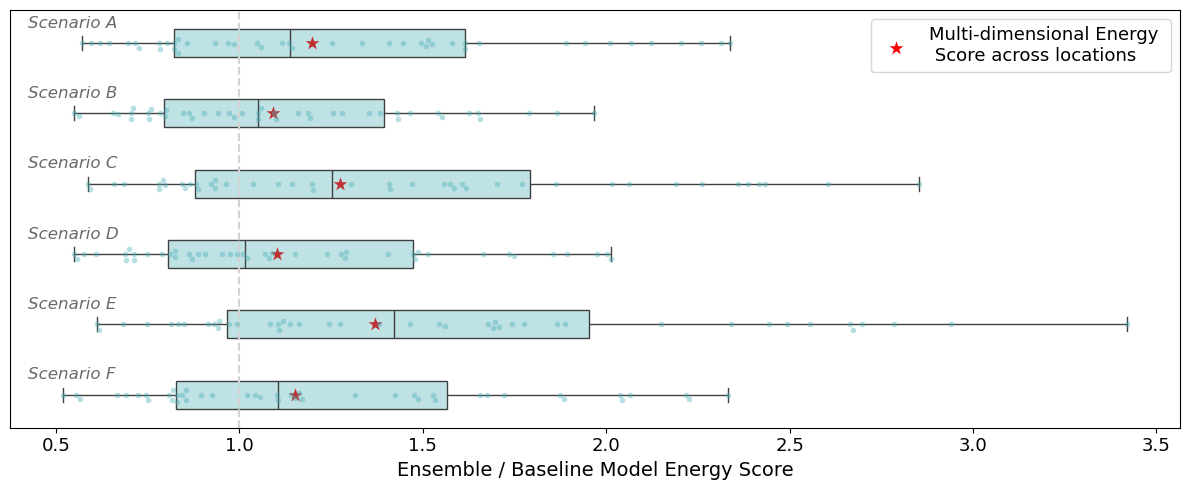

In [118]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
#plt.subplots_adjust(hspace=4)
i=1

baseline = pd.read_pickle('../fludat/flu-baseline_energyscore_118.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})

energyscoresdf = pd.read_pickle("../fludat/energyscore_trajensemble_rd4_hosp_118.pkl")
energyscoresdf['target'] = 'inc hosp'

# calculate energy score ratio
ES_ratiodf = energyscoresdf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']    
rankinfo = ES_ratiodf[ES_ratiodf.location!='11']


my_order = rankinfo.Label.unique()

g = sns.boxplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order, color = '#17B1BF', width=0.4,
               showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
# plot underlying distribution
sns.swarmplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order,color = "#49AFB7",alpha = .4,size=4,
              orient="h")  

g.set(yticklabels=[])
g.set(yticks=[])

plt.ylabel('', fontsize=15)
plt.xlabel('Ensemble / Baseline Model Energy Score', fontsize=14)

i+=1 
#plt.title(scenario, fontsize=14)
#plt.xlim([0, 13])


mobs_multitarget = pd.read_csv('../fludat/multitarget_ensemble_ratio_median.csv')

sns.scatterplot(x='ES_ratio',y='Label',data=mobs_multitarget,color='red',s=200,marker='*',
                label='Multi-dimensional Energy \n Score across locations')

plt.legend(fontsize=13)

plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)


a = 0
for mod in list(my_order):
    plt.text(0.425,a-.22, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)
plt.tight_layout()

plt.savefig('../figs/ensemble_ESdist_multi_1112.pdf')
plt.show()
